### Here I have codes for denoising signals in time series. Depending on the signal and the type of noise you are dealing with, the denoising technique would be different.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy.io as sio
from scipy import *
import scipy.signal
from copy import copy, deepcopy
import warnings
warnings.filterwarnings('ignore')


---
# Running mean
---


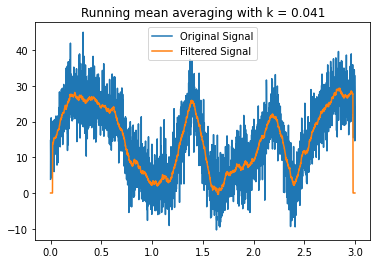

In [2]:
sr   = 1000 # Hz
time = np.arange(0,3,1/sr)
n    = len(time)
p    = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl  = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise = noiseamp * np.random.randn(n)
sig   = ampl + noise

filtered_sig = np.zeros(len(sig))
k = 20

# implement the running mean filter
for i in range(0 + k, len(sig)-k):
    filtered_sig[i] = np.mean(sig[i-k : i+k])

plt.plot(time, sig, label = 'Original Signal')
plt.plot(time, filtered_sig, label = 'Filtered Signal')
plt.legend()
plt.title('Running mean averaging with k = '+ str((2*k + 1)/sr))
plt.show()


---
# Guassian Smoothing
---


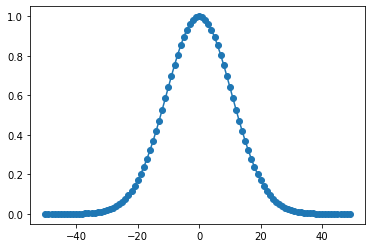

In [4]:
sr   = 1000 # Hz
time = np.arange(0,3,1/sr)
n    = len(time)
p    = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl  = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise = noiseamp * np.random.randn(n)
sig   = ampl + noise

## create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in ms
k = 50
# normalized time vector in ms
t_guassian = 1000 * np.arange(-k,k)/sr

# create Gaussian window
guassian = np.exp(-4 * np.log(2) * t_guassian**2/fwhm**2)

# compute empirical FWHM


# show the Gaussian
plt.plot(t_guassian, guassian, 'o-')

# then normalize Gaussian to unit energy
guassian = guassian/np.sum(guassian)

In [5]:
def guassian_smoothing(signal, k):
    
    sr = 1000
    fwhm = 25
    t_guassian = 1000 * np.arange(-k,k)/sr

    guassian = np.exp(-4 * np.log(2) * t_guassian**2/fwhm**2)
    guassian = guassian/np.sum(guassian)
    
    filtered_sig = np.zeros(len(signal))
    
    for i in range(0+k, len(signal)-k):
        filtered_sig[i] = np.sum(signal[i-k : i+k] * guassian)

    plt.plot(signal, 'r', label = 'Original Signal')
    plt.plot(filtered_sig, 'b', label = 'Gaussian Filtered')
    plt.title('Gaussian smoothing filter')
    plt.xlabel('Time(ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

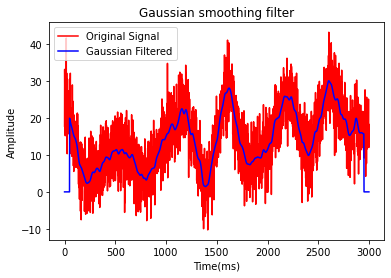

In [6]:
guassian_smoothing(sig, 50)


---
# Gaussian-smooth a spike time series
---


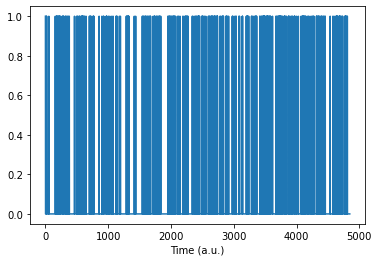

In [7]:
## generate time series of random spikes

# number of spikes
n = 300

# inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp( np.random.randn(n) )*10)

# generate spike time series
spikets = np.zeros(int(np.sum(isi)))

for i in range(0,n):
    spikets[ int(np.sum(isi[0:i])) ] = 1


# plot
plt.plot(spikets)
plt.xlabel('Time (a.u.)')
plt.show()

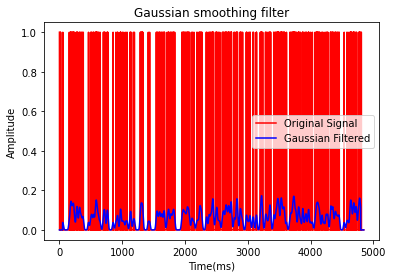

In [8]:
guassian_smoothing(spikets, 50)


---
# Denoising via TKEO
---


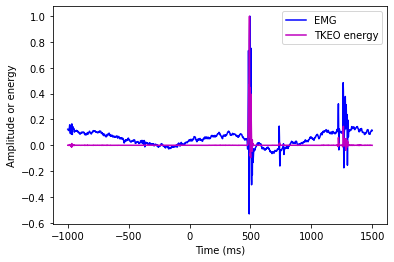

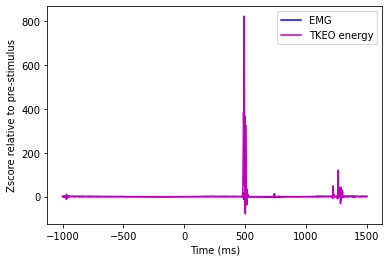

In [9]:
# import data
emgdata = sio.loadmat('emg4TKEO.mat')

# extract needed variables
emgtime = emgdata['emgtime'][0]
emg  = emgdata['emg'][0]

# initialize filtered signal
emg_filtered = np.zeros(len(emg))

emg_filtered[1:-1] = emg[1:-1]**2 - emg[0:-2] * emg[2:]

time0 = np.argmin(emgtime**2)

emg_z = (emg - np.mean(emg[:time0]))/np.std(emg[:time0])
emg_filtered_z = (emg_filtered - np.mean(emg_filtered[:time0]))/np.std(emg_filtered[:time0])

## plot
# plot "raw" (normalized to max.1)
plt.plot(emgtime,emg/np.max(emg),'b',label='EMG')
plt.plot(emgtime,emg_filtered/np.max(emg_filtered),'m',label='TKEO energy')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude or energy')
plt.legend()
plt.show()

# plot zscored
plt.plot(emgtime,emg_z,'b',label='EMG')
plt.plot(emgtime,emg_filtered_z,'m',label='TKEO energy')

plt.xlabel('Time (ms)')
plt.ylabel('Zscore relative to pre-stimulus')
plt.legend()
plt.show()



---
# Median filter to remove spike noise
---



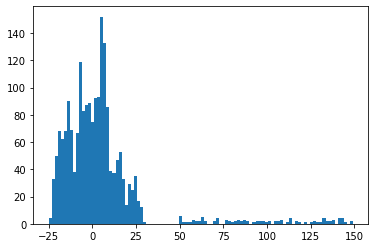

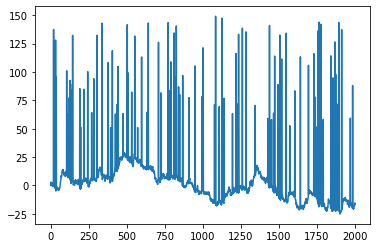

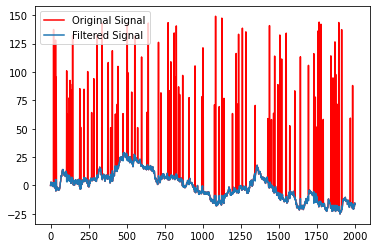

In [6]:
# create signal
n = 2000
signal = np.cumsum(np.random.randn(n))


# proportion of time points to replace with noise
propnoise = .05

# find noise points
noisepnts = np.random.permutation(n)
noisepnts = noisepnts[0:int(n*propnoise)]

# generate signal and replace points with noise
signal[noisepnts] = 50+np.random.rand(len(noisepnts))*100


# use hist to pick threshold
plt.hist(signal,100)
plt.show()

plt.plot(signal)
plt.show()

# visual-picked threshold
k = 100


# find data values above the threshold
spikes_indx = np.where(signal > threshold)[0]

# initialize filtered signal
filtered_signal = deepcopy(signal)

# loop through suprathreshold points and set to median of k
for i in range(len(spikes_indx)):
    
    lower_limit = max(0, spikes_indx[i]-k)
    upper_limit = min(spikes_indx[i]+k , n)
    
    filtered_signal[spikes_indx[i]] = np.median(signal[lower_limit : upper_limit])
    

plt.plot(signal, 'r', label = 'Original Signal')
plt.plot(filtered_signal, label = 'Filtered Signal')
plt.legend()
plt.show()
    



---
# Remove linear trend
---


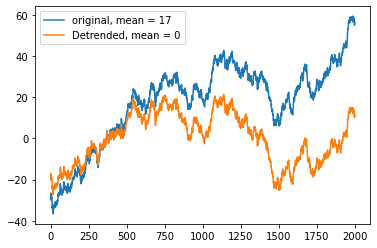

In [72]:
# create signal with linear trend imposed
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30,30,n)

# linear detrending
detrended_signal = scipy.signal.detrend(signal)

# get means
signal_mean = np.mean(signal)
detrended_mean = np.mean(detrended_signal)

# plot signal and detrended signal
plt.plot(signal, label = 'original, mean = %d' %signal_mean)
plt.plot(detrended_signal, label = 'Detrended, mean = %d' %detrended_mean)
plt.legend()
plt.show()



---
# Remove nonlinear trend with polynomials
---


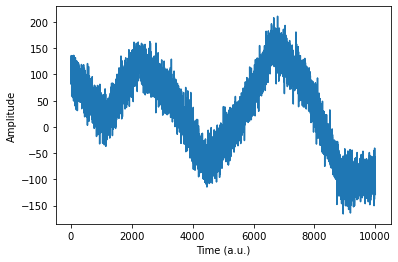

In [3]:
## generate signal with slow polynomial artifact

n = 10000
t = range(n)
k = 10 # number of poles for random amplitudes

slowdrift = np.interp(np.linspace(1,k,n),np.arange(0,k),100*np.random.randn(k))
signal = slowdrift + 20*np.random.randn(n)

# plot
plt.plot(t,signal)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.show()

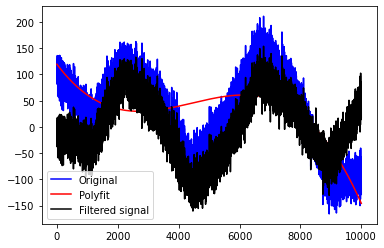

In [4]:
## fit a 3-order polynomial

# polynomial fit (returns coefficients)
num = polyfit(t, signal, 3)


# predicted data is evaluation of polynomial
yHat = polyval(num, t)


# compute residual (the cleaned signal)
res = signal - yHat



# now plot the fit (the function that will be removed)
plt.plot(t,signal,'b',label='Original')
plt.plot(t,yHat,'r',label='Polyfit')
plt.plot(t,res,'k',label='Filtered signal')

plt.legend()
plt.show()

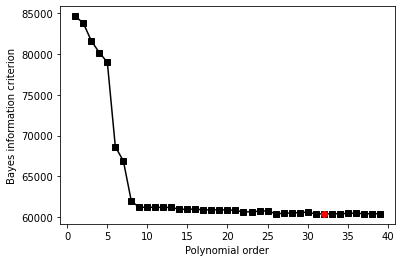

In [12]:
## Bayes information criterion to find optimal order

# possible orders
orders = np.arange(1, 40)


# sum of squared errors (sse is reserved!)

bic = np.zeros(len(orders))

# loop through orders
for i in range(len(orders)):
    num = polyfit(t, signal, orders[i])
    yHat = polyval(num, t)
    res = signal - yHat
    epsilon = np.sum(res**2)/n
    bic[i] = n * np.log(epsilon) + orders[i] * np.log(n)



# Bayes information criterion


# best parameter has lowest BIC
best_order = np.argmin(bic)


# plot the BIC
plt.plot(orders, bic, 'ks-')
plt.plot(orders[best_order], bic[orders[best_order]], 'ro')
plt.xlabel('Polynomial order')
plt.ylabel('Bayes information criterion')
plt.show()

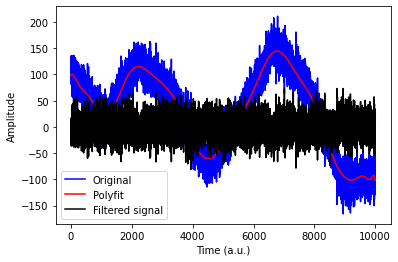

In [15]:
## now repeat filter for best (smallest) BIC

# polynomial fit
best_num = polyfit(t, signal, orders[best_order])

# estimated data based on the coefficients
best_fit = polyval(best_num, t)

# filtered signal is residual
best_res = best_fit - signal

## plotting
plt.plot(t,signal,'b',label='Original')
plt.plot(t,best_fit,'r',label='Polyfit')
plt.plot(t,best_res,'k',label='Filtered signal')

plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')

plt.legend()
plt.show()


---
# Averaging multiple repetitions (time-synchronous averaging)
---


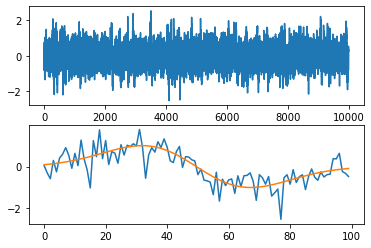

In [16]:
## simulate data

# create event (derivative of Gaussian)
k = 100 # duration of event in time points
event = np.diff(np.exp( -np.linspace(-2,2,k+1)**2 ))
event = event/np.max(event) # normalize to max=1

# event onset times
Nevents = 30
onsettimes = np.random.permutation(10000-k)
onsettimes = onsettimes[0:Nevents]

# put event into data
data = np.zeros(10000)
for ei in range(Nevents):
    data[onsettimes[ei]:onsettimes[ei]+k] = event

# add noise
data = data + .5*np.random.randn(len(data))

# plot data
plt.subplot(211)
plt.plot(data)

# plot one event
plt.subplot(212)
plt.plot(range(k), data[onsettimes[3]:onsettimes[3]+k])
plt.plot(range(k), event)
plt.show()

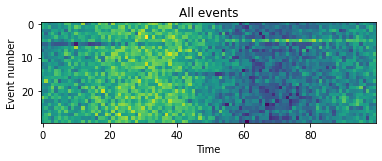

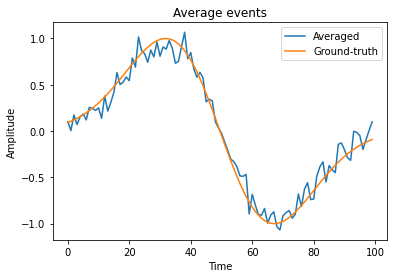

In [61]:
## extract all events into a matrix
datamatrix = np.zeros((Nevents,k))

for ei in range(0,Nevents):
    datamatrix[ei,:] = data[onsettimes[ei]:onsettimes[ei]+k]

plt.imshow(datamatrix)
plt.xlabel('Time')
plt.ylabel('Event number')
plt.title('All events')
plt.show()

plt.plot(range(0,k),np.mean(datamatrix,axis=0),label='Averaged')
plt.plot(range(0,k),event,label='Ground-truth')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Average events')
plt.show()



---
# Remove artifact via least-squares template-matching
---


In [76]:
# load dataset
matdat = sio.loadmat('templateProjection.mat')
EEGdat = matdat['EEGdat']
eyedat = matdat['eyedat']
timevec = matdat['timevec'][0]
MN = np.shape(EEGdat) # matrix sizes

# initialize residual data

X = np.ones((MN[0], 2))
res = zeros(np.shape(EEGdat))

# loop over trials
for trial in range(0, MN[1]):
    
    # build the least-squares model as intercept and EOG from this trial
    X[:, 1] = eyedat[:, trial]

    
    # compute regression coefficients for EEG channel
    beta = np.linalg.inv(np.matrix.transpose(X) @ X) @ np.matrix.transpose(X) @ EEGdat[:, trial]
    
    # predicted data
    yHat = X @ beta
    
    # new data are the residuals after projecting out the best EKG fit
    res[:, trial] = EEGdat[:, trial] - X @ beta

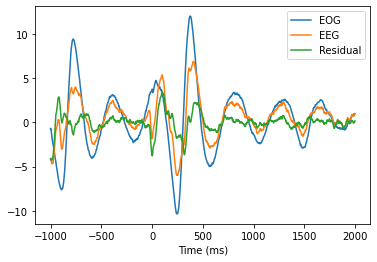

In [78]:
### plotting
plt.plot(timevec,np.mean(eyedat,axis=1),label='EOG')
plt.plot(timevec,np.mean(EEGdat,axis=1),label='EEG')
plt.plot(timevec,np.mean(res, axis=1),label='Residual')

plt.xlabel('Time (ms)')
plt.legend()
plt.show()

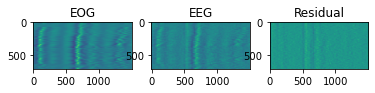

In [95]:
# show all trials in a map

plt.subplot(131)
plt.imshow(eyedat.T)
plt.title('EOG')

plt.subplot(132)
plt.imshow(EEGdat.T)
plt.title('EEG')

plt.subplot(133)
plt.imshow(res.T)
plt.title('Residual')

plt.show()